In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np

In [4]:
from PIL import Image

def read_calibration_data(filepath):
    calibration_data = {}
    with open(filepath, 'r') as file:
        for line in file:
            if '=' in line:
                key, value = line.strip().split('=', 1)
                try:
                    # Convert numerical values to floats
                    calibration_data[key] = float(value)
                except ValueError:
                    # Keep string values as-is
                    calibration_data[key] = value
    return calibration_data

def calculate_offsets(calibration_data):
    # Calculate pixels per meter
    ppm_x = calibration_data["optical-calibration.image-width"] / calibration_data["optical-calibration.region.width"]
    ppm_y = calibration_data["optical-calibration.image-height"] / calibration_data["optical-calibration.region.height"]
    
    # Calculate the global position in pixels
    global_x = calibration_data["optical-calibration.scanner-environment.xy-scanner.motorstage.position.x"]*ppm_y #calibration_data["optical-calibration.region.x"] - calibration_data["optical-calibration.scanner-environment.xy-scanner.motorstage.position.x"]
    global_y = calibration_data["optical-calibration.scanner-environment.xy-scanner.motorstage.position.y"]*ppm_x #calibration_data["optical-calibration.region.y"] - calibration_data["optical-calibration.scanner-environment.xy-scanner.motorstage.position.y"]
    
    # Calculate the offsets
    offset_x = calibration_data["optical-calibration.scanner-environment.xy-scanner.motorstage.position.x"]
    offset_y = calibration_data["optical-calibration.scanner-environment.xy-scanner.motorstage.position.x"]
    
    return ppm_x, ppm_y, global_x, global_y, offset_x, offset_y

def create_composite_image(image_paths, calibration_files, output_path):
    # Read calibration data from files
    calibration_datas = [read_calibration_data(file) for file in calibration_files]
    
    # Load images and rotate them by -90 degrees to align with the global coordinate system
    images = [Image.open(path).rotate(90, expand=True) for path in image_paths]
    
    # Calculate offsets and pixels per meter for each image
    calculations = [calculate_offsets(data) for data in calibration_datas]
    
    # Determine the canvas size
    canvas_width_meters = max([abs(c[2]) + data["optical-calibration.image-width"] for c, data in zip(calculations, calibration_datas)]) #c[2] is global_x
    canvas_height_meters = max([abs(c[3]) + data["optical-calibration.image-width"] for c, data in zip(calculations, calibration_datas)]) #c[3] is global_y
    
    # Assume the pixels per meter is the same for both images, as indicated by calibration data
    ppm_x, ppm_y = calculations[0][:2] 
    
    # Create the canvas
    canvas_width_pixels = int(round(canvas_width_meters))
    canvas_height_pixels = int(round(canvas_height_meters))
    canvas = Image.new('RGB', (canvas_width_pixels, canvas_height_pixels), (0, 0, 0))
    
    # Paste images onto the canvas
    for (ppm_x, ppm_y, global_x, global_y, offset_x, offset_y), image in zip(calculations, images):
        position_x = int(round((offset_x)))
        position_y = int(round((offset_y)))
        canvas.paste(image, (position_x, position_y))
    
    # Save the composite image
    canvas.save(output_path)
    print(f"Composite image saved to {output_path}")


In [5]:
import os
import glob

# Directory containing the 'tiling_x' folders
parent_directory = './tiling/'

# Glob pattern to match folders
folder_pattern = os.path.join(parent_directory, 'tiling-*')
folders = sorted(glob.glob(folder_pattern), key=lambda x: os.path.basename(x).split('-')[1:])

# Lists to hold the paths
image_paths = []
calibration_files = []
tiling_vars = {}

# Iterate through each folder
for folder in folders:
    # Extract folder name to dynamically create variable-like dictionary keys
    folder_name = os.path.basename(folder)
    tiling_vars[folder_name] = folder

    # Find all jpg images in the folder
    jpg_files = glob.glob(os.path.join(folder, 'snapshot-*.jpg'))
    image_paths.extend(jpg_files)

    # Find all calibration files in the folder
    cal_files = glob.glob(os.path.join(folder, 'optical-calibration-*.txt'))
    calibration_files.extend(cal_files)

    # Optionally open the first calibration file found in each folder
    if cal_files:
        first_cal_file = cal_files[0]
        print(f"Opening file: {first_cal_file}")
        # Here you can add your logic to open and process the file

# Output paths for demonstration purposes
output_path = './result.jpg'

# Print variables and paths for verification
print(f"Tiling folder variables: {tiling_vars}")
print(f"Image paths: {image_paths}")
print(f"Calibration files: {calibration_files}")
print(f"Output path: {output_path}")





Opening file: ./tiling/tiling-09.53.06.378/optical-calibration-2024.01.30-09.53.08-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-09.53.28.880/optical-calibration-2024.01.30-09.53.37-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-09.53.50.330/optical-calibration-2024.01.30-09.54.00-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-09.54.20.863/optical-calibration-2024.01.30-09.54.30-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-09.55.04.169/optical-calibration-2024.01.30-09.55.19-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-09.55.54.288/optical-calibration-2024.01.30-09.56.20-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-09.56.50.419/optical-calibration-2024.01.30-09.57.12-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-09.59.36.087/optical-calibration-2024.01.30-09.59.47-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-10.00.30.819/optical-calibration-2024.01.30-10.00.48-snapshot-000.jpk-opt-

In [6]:
calibrations = []
for file in calibration_files:
    calibration_data = read_calibration_data(file)
    calibrations.append(calibration_data)

calculations = []
for calibration in calibrations:
    calculation_data = calculate_offsets(calibration)
    calculations.append(calculation_data)

In [7]:
df = pd.DataFrame(calculations, columns = ['ppm_x', 'ppm_y', 'global_x', 'global_y', 'x in m', 'y in um'])

In [8]:
y_max = df.max()[3]
x_max = df.max()[2]
df['y_offset'] = abs(df['global_y']-abs(y_max))
df['x_offset'] = abs((df['global_x']-x_max))

/tmp/ipykernel_41288/3996158045.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_max = df.max()[3]
/tmp/ipykernel_41288/3996158045.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_max = df.max()[2]


In [9]:
df

,ppm_x,ppm_y,global_x,global_y,x in m,y in um,y_offset,x_offset
0,406636.920644,406617.227069,-512.232822,-1169.637130,-0.001260,-0.001260,1339.881585,944.425560
1,406636.920644,406617.227069,-518.194334,-776.231429,-0.001274,-0.001274,946.475884,950.387073
2,406636.920644,406617.227069,-522.462236,-299.133913,-0.001285,-0.001285,469.378368,954.654974
3,406636.920644,406617.227069,-521.581558,170.244455,-0.001283,-0.001283,0.000000,953.774296
4,406636.920644,406617.227069,432.192739,117.970926,0.001063,0.001063,52.273529,0.000000
5,406636.920644,406617.227069,-530.388338,-1720.405111,-0.001304,-0.001304,1890.649566,962.581076
6,406636.920644,406617.227069,-1418.518249,-291.076206,-0.003489,-0.003489,461.320661,1850.710988
7,406636.920644,406617.227069,-1420.753817,-957.292848,-0.003494,-0.003494,1127.537303,1852.946555
8,406636.920644,406617.227069,-1512.615309,116.210419,-0.003720,-0.003720,54.034036,1944.808047


In [10]:
canvas_width_pixels = df['y_offset'].max()+1024 #c[2] is global_x
canvas_height_pixels = df['x_offset'].max()+1024 #c[3] is global_y

# Create the canvas
canvas_width_pixels = int(canvas_width_pixels)
canvas_height_pixels = int(canvas_height_pixels)
canvas = Image.new('RGB', (canvas_width_pixels, canvas_height_pixels), (0, 0, 0))


# List to hold the cropped images
cropped_images = []

# Loop through each image path
for path in image_paths:
    # Open and rotate the image (though here rotation is set to 0, so it's not actually changing the image)
    image = Image.open(path).rotate(0, expand=True)
    
    # Get the size of the image
    width, height = image.size
    
    # Define the cropping box. Remove the right 200 pixels
    crop_box = (0, 0, width - 100, height)
    
    # Crop the image
    cropped_img = image.crop(crop_box)
    # Add the cropped image to the list
    cropped_images.append(cropped_img)

df['image_path'] = cropped_images


In [11]:
# Step 2: Sort the DataFrame by 'y_offset' in descending order
df_sorted = df.sort_values(by='y_offset', ascending=False)
df_sorted = df_sorted.sort_values(by='x_offset', ascending=True)
df_sorted.loc[df_sorted['x_offset'] < 100, 'x_offset'] += 20
df_sorted.loc[df_sorted['x_offset'] < 100, 'y_offset'] -= 20
df_sorted.loc[df_sorted['x_offset'] > 1000, 'x_offset'] -= 30
df_sorted.loc[df_sorted['x_offset'] > 1000, 'y_offset'] += 10

In [12]:
# Assuming `df` is your DataFrame and `cropped_images` is a list of image paths
# Step 1: Add the image paths to the DataFrame
df_sorted = df_sorted.sort_values(by='y_offset', ascending=False)

# Now you can loop through the sorted DataFrame
for i, row in df_sorted.iterrows():
    position_x = int(row['x_offset'])
    position_y = int(row['y_offset'])

    
    # Paste the image on the canvas at the specified position
    # Note: Adjust the order of position_x and position_y if necessary
    canvas.paste(row['image_path'], (position_y, position_x))

# Save the composite image
output_path = './result_new.jpg'
canvas.save(output_path)
print(f"Composite image saved to {output_path}")


Composite image saved to ./result_new.jpg


In [13]:
afm = pd.read_csv("./ZWV14_processed_forcecurves.tsv", sep = "\t")
afm['X Position'] = abs((afm['X Position'])*df['ppm_x'][0])-abs(y_max)+1024+50
afm['Y Position'] = abs(((afm['Y Position'])*df['ppm_x'][1]*(-1)))+1024-290




In [14]:
df['ppm_x'][0]

406636.92064426054

In [15]:
afm.to_csv("./ZWV14_new/afm.csv", sep = ",")

/home/ubuntu/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


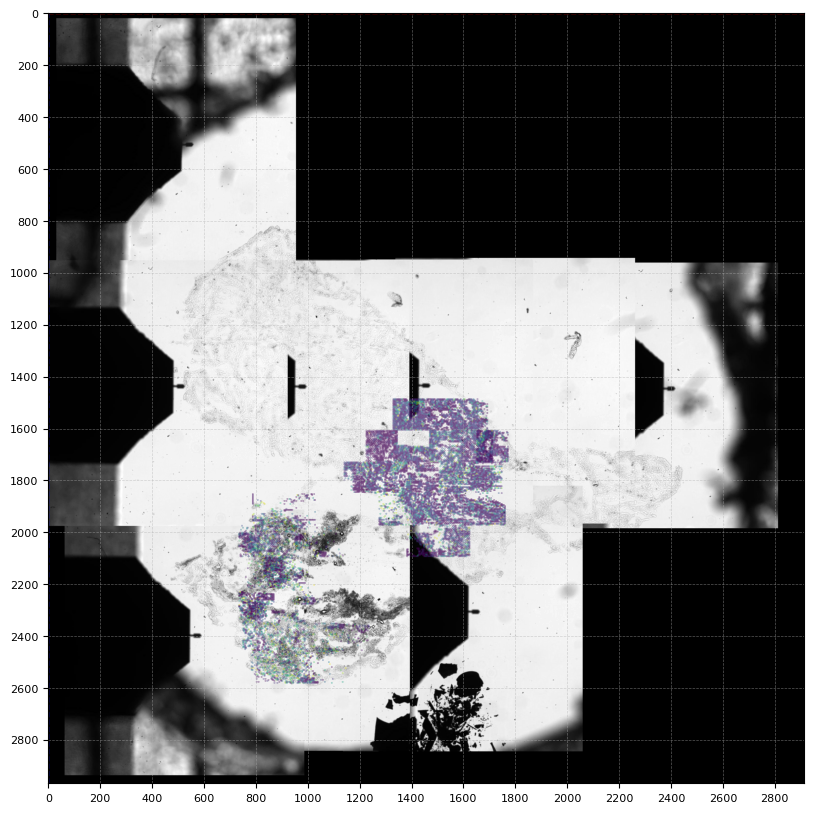

In [16]:
# Filter the data to exclude outliers
filtered_afm = afm[afm["Young's Modulus [Pa]"] < 10000]
filtered_afm = filtered_afm[filtered_afm["Young's Modulus [Pa]"] > 10]

afm_slide = cv2.imread('./result_new.jpg', cv2.IMREAD_GRAYSCALE)

# Ensure that the dimensions of the canvas match the resized image
canvas_new = np.zeros_like(afm_slide)

# Check if the dimensions match
if canvas_new.shape[:2] == afm_slide.shape[:2]:
    # Draw the resized image on the canvas
    canvas_new = cv2.addWeighted(canvas_new, 1, afm_slide, 1, 0)  # Overlay the image on the canvas

    # Create a scatter plot on top of the canvas
    plt.figure(figsize=(10, 10))
    plt.imshow(canvas_new, cmap='gray')  # Specify the grayscale colormap

    plt.scatter((filtered_afm['Y Position']), filtered_afm['X Position'], 
                c=filtered_afm["Young's Modulus [Pa]"], s=0.1, alpha=0.5)

    plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Horizontal red dashed line for the X-axis
    plt.axvline(0, color='blue', linestyle='--', linewidth=1)  # Vertical blue dashed line for the Y-axis

    # Specify axis tick positions and labels
    plt.xticks(np.arange(0, canvas_new.shape[1], step=200), fontsize=8)
    plt.yticks(np.arange(0, canvas_new.shape[0], step=200), fontsize=8)

    plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)  # Add grid lines

    plt.savefig('Location_all.png', bbox_inches='tight')

    plt.show()
else:
    print("Error: Image dimensions do not match the canvas dimensions.")

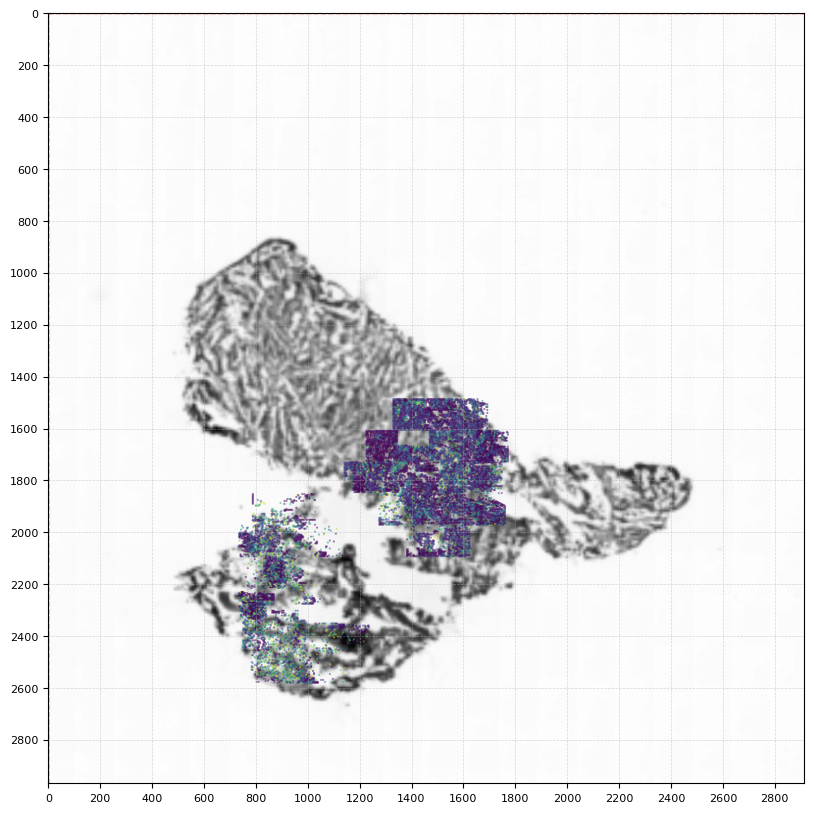

In [18]:
afm_slide = cv2.imread('./ZWV14_new/transformed_image-new2.tif', cv2.IMREAD_GRAYSCALE)

# Ensure that the dimensions of the canvas match the resized image
canvas_new = np.zeros_like(afm_slide)

# Check if the dimensions match
if canvas_new.shape[:2] == afm_slide.shape[:2]:
    # Draw the resized image on the canvas
    canvas_new = cv2.addWeighted(canvas_new, 1, afm_slide, 1, 0)  # Overlay the image on the canvas

    # Create a scatter plot on top of the canvas
    plt.figure(figsize=(10, 10))
    plt.imshow(canvas_new, cmap='gray')  # Specify the grayscale colormap

    plt.scatter((filtered_afm['Y Position']), filtered_afm['X Position'], 
                c=filtered_afm["Young's Modulus [Pa]"], s=0.3, alpha= 0.5)

    plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Horizontal red dashed line for the X-axis
    plt.axvline(0, color='blue', linestyle='--', linewidth=1)  # Vertical blue dashed line for the Y-axis

    # Specify axis tick positions and labels
    plt.xticks(np.arange(0, canvas_new.shape[1], step=200), fontsize=8)
    plt.yticks(np.arange(0, canvas_new.shape[0], step=200), fontsize=8)

    plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)  # Add grid lines

    plt.show()
else:
    print("Error: Image dimensions do not match the canvas dimensions.")